In [1]:
# Plant Disease Detection using CNN

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


## Creating Dataset

In [3]:
def create_plant_data(num_samples=1500):
    X = np.zeros((num_samples, 64, 64, 3), dtype=np.uint8)
    y = np.random.choice([0, 1], size=num_samples, p=[0.5, 0.5])
    
    for i in range(num_samples):
        img = np.random.rand(64, 64, 3) * 100 + 50
        
        if y[i] == 0:
            img[:, :, 1] += np.random.randint(60, 100)
            img[:, :, 0] -= np.random.randint(10, 30)
            img[:, :, 2] -= np.random.randint(10, 30)
            
            for _ in range(3):
                y_spot = np.random.randint(10, 54)
                x_spot = np.random.randint(10, 54)
                img[y_spot:y_spot+10, x_spot:x_spot+10, 1] += 30
                
        else:
            img[:, :, 0] += np.random.randint(40, 70)
            img[:, :, 2] += np.random.randint(30, 60)
            img[:, :, 1] -= np.random.randint(20, 50)
            
            for _ in range(np.random.randint(2, 5)):
                y_spot = np.random.randint(5, 59)
                x_spot = np.random.randint(5, 59)
                spot_size = np.random.randint(3, 8)
                img[y_spot:y_spot+spot_size, x_spot:x_spot+spot_size, 0] += 50
                img[y_spot:y_spot+spot_size, x_spot:x_spot+spot_size, 1] -= 30
        
        X[i] = np.clip(img, 0, 255).astype(np.uint8)
    
    return X, y

X_data, y_data = create_plant_data(1500)
print(f"Dataset: {X_data.shape}, Healthy: {np.sum(y_data == 0)}, Diseased: {np.sum(y_data == 1)}")

Dataset: (1500, 64, 64, 3), Healthy: 761, Diseased: 739


## Visualising Data

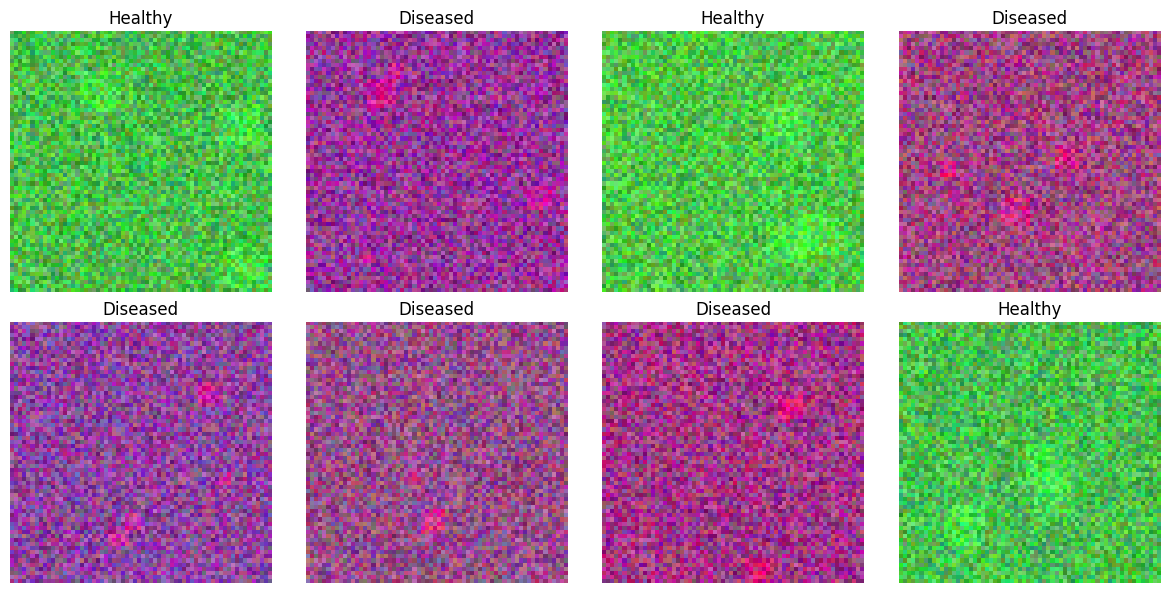

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    row, col = i // 4, i % 4
    axes[row, col].imshow(X_data[i])
    status = "Diseased" if y_data[i] == 1 else "Healthy"
    axes[row, col].set_title(status, fontsize=12)
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

## Preprocessing Data

In [5]:
X_normalized = X_data.astype('float32') / 255.0
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_data, test_size=0.2, random_state=42, stratify=y_data
)
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 1200
Testing samples: 300


## CNN Model

In [6]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 359,681 (1.37 MB)

 Trainable params: 359,681 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [7]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=15,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9352 - loss: 0.1879 - val_accuracy: 1.0000 - val_loss: 5.3362e-20
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9992 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 3.8275e-18
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9944 - loss: 0.0170 - val_accuracy: 1.0000 - val_loss: 2.6540e-25
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 1.0000 - loss: 1.6756e-08 - val_accuracy: 1.0000 - val_loss: 4.5573e-24
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 1.0000 - loss: 2.5023e-10 - val_accuracy: 1.0000 - val_loss: 4.8356e-24
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 1.0000 - loss: 5.0504e-08 - val_accuracy: 1.0000 - val_loss: 4.8401e-24
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 1.0000 - loss: 8.8819e-10 - val_accuracy: 1.0000 - val_loss: 4.8390e-24
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 1.00

## Evaluate Model

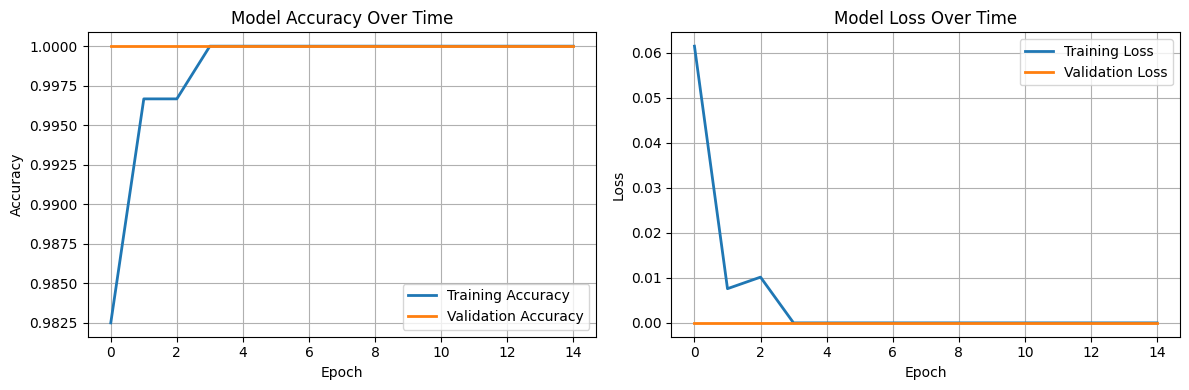

Final Test Accuracy: 100.00%


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy Over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss Over Time')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Accuracy: {test_accuracy:.2%}")

## Result

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       152
    Diseased       1.00      1.00      1.00       148

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



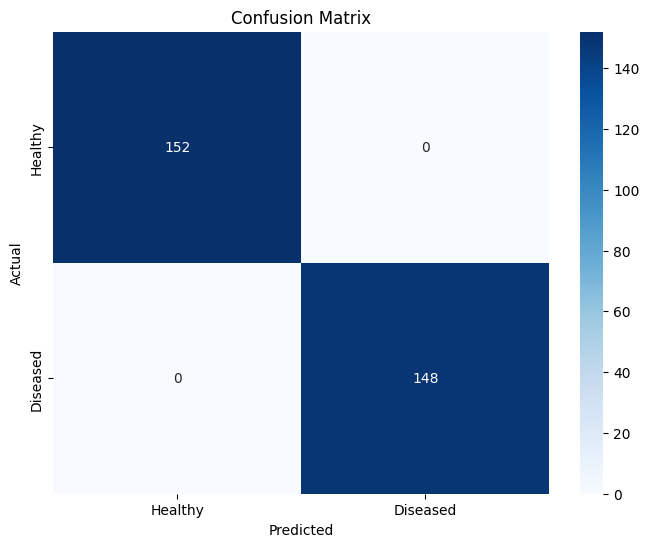

In [9]:
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Diseased']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'Diseased'], 
            yticklabels=['Healthy', 'Diseased'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Random Predictions


--- Test 1 ---


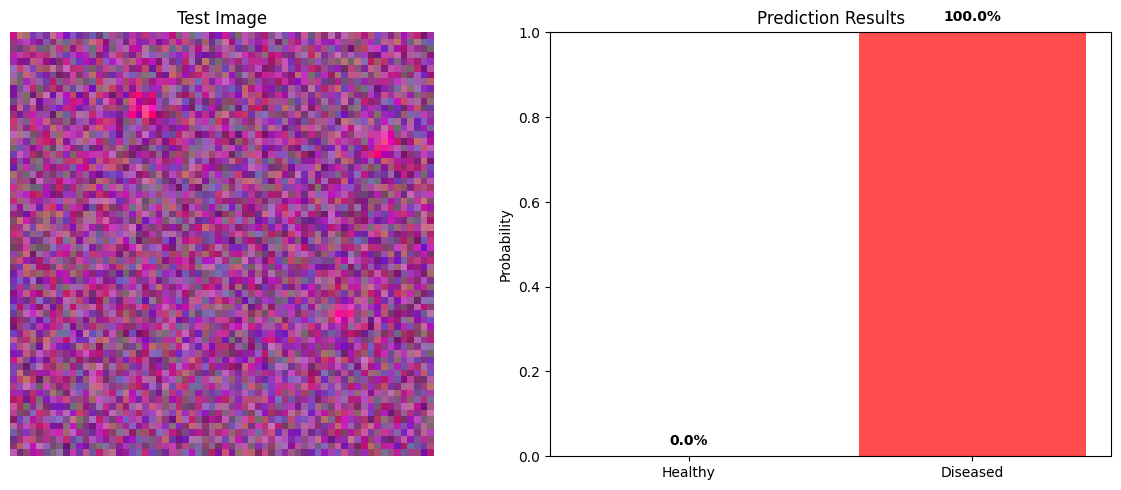

Actual: Diseased
Predicted: Diseased
Confidence: 100.0%

--- Test 2 ---


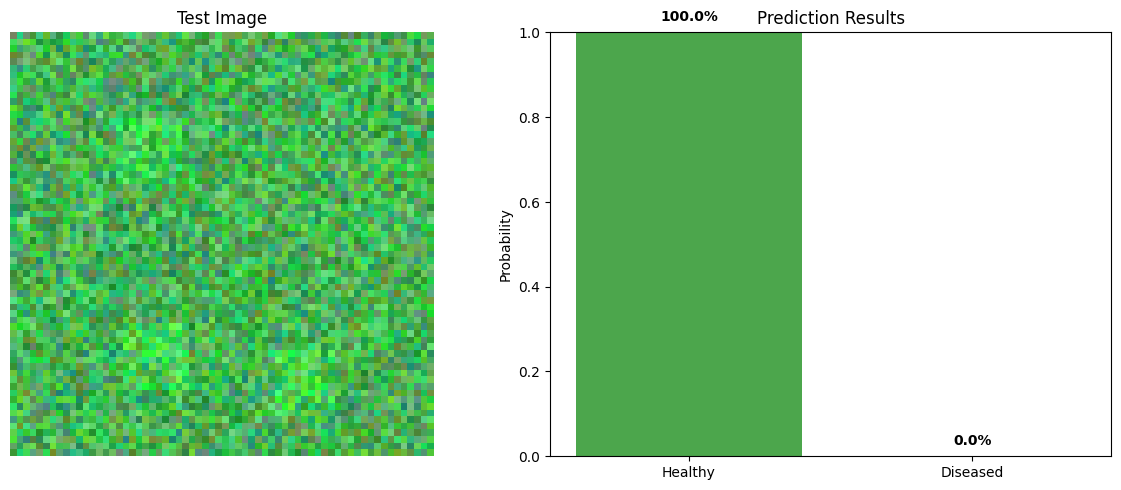

Actual: Healthy
Predicted: Healthy
Confidence: 100.0%

--- Test 3 ---


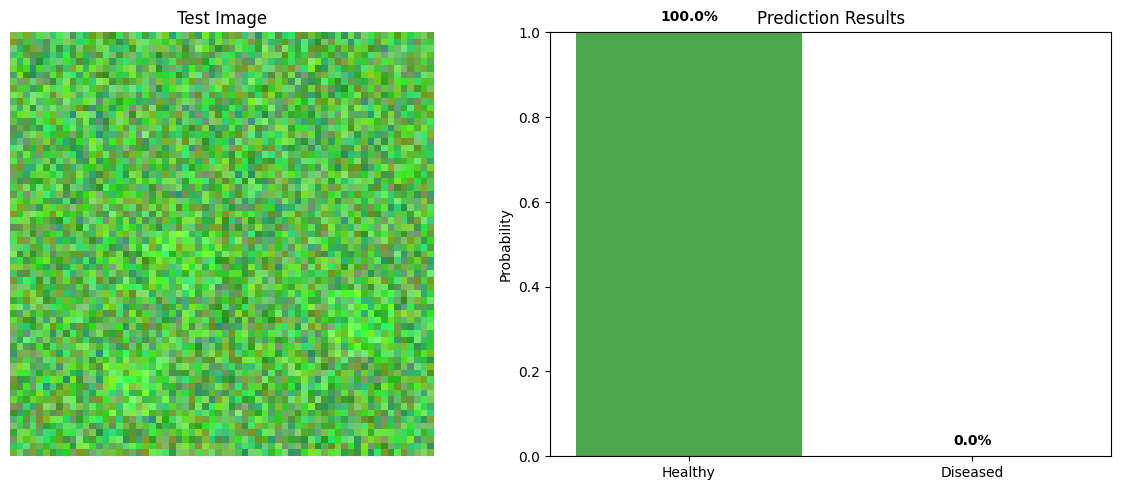

Actual: Healthy
Predicted: Healthy
Confidence: 100.0%


In [10]:
def test_single_prediction():
    idx = np.random.randint(0, len(X_test))
    test_img = X_test[idx:idx+1]
    actual = y_test[idx]
    pred_prob = model.predict(test_img, verbose=0)[0][0]
    predicted = 1 if pred_prob > 0.5 else 0
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.imshow(X_test[idx])
    ax1.set_title('Test Image')
    ax1.axis('off')
    
    labels = ['Healthy', 'Diseased']
    probs = [1-pred_prob, pred_prob]
    colors = ['green', 'red']
    bars = ax2.bar(labels, probs, color=colors, alpha=0.7)
    ax2.set_ylim(0, 1)
    ax2.set_title('Prediction Results')
    ax2.set_ylabel('Probability')
    
    for bar, prob in zip(bars, probs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{prob:.1%}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    actual_status = "Diseased" if actual == 1 else "Healthy"
    pred_status = "Diseased" if predicted == 1 else "Healthy"
    confidence = max(pred_prob, 1-pred_prob)
    
    print(f"Actual: {actual_status}")
    print(f"Predicted: {pred_status}")
    print(f"Confidence: {confidence:.1%}")

for i in range(3):
    print(f"\n--- Test {i+1} ---")
    test_single_prediction()

## SAVING MODEL

In [ ]:
model.save('plant_disease_detection.keras')
print("Project model saved successfully!")

Project model saved successfully!
